In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [3]:
#parth - downloading data
'''
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download niteshfre/chessman-image-dataset
! unzip chessman-image-dataset.zip
'''

'\n! pip install kaggle\n! mkdir ~/.kaggle\n! cp kaggle.json ~/.kaggle/\n! chmod 600 ~/.kaggle/kaggle.json\n! kaggle datasets download niteshfre/chessman-image-dataset\n! unzip chessman-image-dataset.zip\n'

In [4]:
# Downloading Kaggle Dataset
'''
!pip install kaggle -q
!kaggle datasets download -d niteshfre/chessman-image-dataset
os.listdir()
!unzip chessman-image-dataset.zip
'''

'\n!pip install kaggle -q\n!kaggle datasets download -d niteshfre/chessman-image-dataset\nos.listdir()\n!unzip chessman-image-dataset.zip\n'

In [5]:
os.chdir('/content/drive/MyDrive/Kaggle')

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GaussianNoise, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Input
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [7]:
from keras.preprocessing.image import ImageDataGenerator
class_names = ['Bishop', 'King','Knight','Pawn','Queen','Rook']
image_size=(224,224)

In [8]:
path = 'Chessman-image-dataset/Chess'
IMAGE_SIZE = [224, 224]
batch = 32

data = keras.preprocessing.image_dataset_from_directory(
    path,
    seed=20,
    class_names=class_names,
    image_size=IMAGE_SIZE,
    label_mode='int',
    batch_size=552
)

Found 552 files belonging to 6 classes.


In [9]:
# Create Training Pairs

def makePairs(images, labels, idx, pairMultiplier = 1):
  # Pairs is a list of image training pairs
  # Index[0] = (image, image) Index[1] = (label, label) -> ((),())
  imagePairs = []
  pairLabels = []

  # Taken from Adrian Rosebrocks Siamese Networks Tutorial
  numClasses = len(np.unique(labels))

  # loop over all images
  for idxA in range(len(images)):
    # grab the current image and label belonging to the current
    # iteration
    currentImage = images[idxA]
    label = labels[idxA]
    for i in range(pairMultiplier):
      # randomly pick an image that belongs to the *same* class
      # label
      idxB = np.random.choice(idx[label])
      posImage = images[idxB]
      # prepare a positive pair and update the images and labels
      # lists, respectively
      imagePairs.append([currentImage, posImage])
      pairLabels.append([1])
      # grab the indices for each of the class labels *not* equal to
      # the current label and randomly pick an image corresponding
      # to a label *not* equal to the current label
      negIdx = np.where(labels != label)[0]
      negImage = images[np.random.choice(negIdx)]
      # prepare a negative pair of images and update our lists
      imagePairs.append([currentImage, negImage])
      pairLabels.append([0])
  # return a 2-tuple of our image pairs and labels
  return (np.array(imagePairs), np.array(pairLabels))

In [10]:
images = []
scaledImages = []
labels = []

# Each element contains a list of indices for the respective label
# Ex: [0] contains a list of indices for the class labeled as "0"
idx = [[], [], [], [], [], []]

for input, output in data.as_numpy_iterator():
  for i in range(len(input)):
    images.append(input[i])
    scaledImages.append(input[i]/255)
    idx[output[i]].append(i)
    labels.append(output[i])

# ((posImg1, posImg2), (posImg1, negImg1))
pair_train, label_train = makePairs(scaledImages, labels, idx, 2)
pair_test, label_test = makePairs(scaledImages, labels, idx)
# pair_train, pair_test, label_train, label_test = sklearn.model_selection.train_test_split(data_pairs_pos_neg[0], data_pairs_pos_neg[1], train_size=0.8,test_size=0.2, random_state=101)

In [11]:
# Taken from Adrian Rosebrocks Siamese Networks Tutorial

def euclideanDistance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [53]:
def createVGGModel1():
    # add preprocessing layer to the front of VGG
    vgg = VGG16(input_shape=(IMAGE_SIZE + [3]), weights='imagenet', include_top=False,classes=2)

    # don't train existing weights
    for layer in vgg.layers:
      layer.trainable = False

    # our layers
    
    # Introduce Noise
    input_layer = keras.layers.Input((224,224,3))
    x = GaussianNoise(0.1)(input_layer)
    x = vgg(x)

    x = Conv2D(64, (1,1), activation='relu')(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = Conv2D(64, (1,1), activation='relu')(x)
    x = Conv2D(64, (1,1), activation='relu')(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = Conv2D(64, (1,1), activation='relu')(x)
    x = Conv2D(64, (1,1), activation='relu')(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = Conv2D(64, (1,1), activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation ='relu')(x)
    x = GlobalAveragePooling2D()(x)
    embedding = Flatten()(x)

    # create a model object
    model = Model(inputs=input_layer, outputs=embedding)

    return model

def createVGGModel2():
    # add preprocessing layer to the front of VGG
    vgg = VGG16(input_shape=(IMAGE_SIZE + [3]), weights='imagenet', include_top=False,classes=6)

    # don't train existing weights
    for layer in vgg.layers:
      layer.trainable = False
  
    # our layers
    
    # Introduce Noise
    input_layer = keras.layers.Input((224,224,3))

    # Pretrained Model
    x = vgg(input_layer)
 
    # our layers 
    x = Flatten()(x)
    x = Dense(125, activation='relu')(x)
    x = GaussianNoise(0.1)(x)
    x = Dense(125, activation='relu')(x)
    x = Dropout(0.2)(x)
    embedding = Flatten()(x)

    # create a model object
    model = Model(inputs=input_layer, outputs=embedding)

    return model

def createCNN():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Flatten()])
  
  return model

def build_siamese_model(inputShape=(224,224,3), embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)
 	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

In [13]:
def createSimpleCNN():

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(1, (1,1), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(1, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(3, (1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(1, (1,1), activation='relu'),
    tf.keras.layers.Conv2D(1, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(3, (1,1), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten()])
  
  return model



In [14]:
def createNN():
    input = Input(shape=(224,224, 3))
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)

    return Model(inputs=input, outputs = x)

In [52]:
# Taken from Adrian Rosebrocks Siamese Networks Tutorial

print("[INFO] building siamese network...")
imgA = Input(shape=(224, 224, 3))
imgB = Input(shape=(224, 224, 3))

model = createVGGModel1()
featureExtractor = model
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# Calculate euclidean distance between both feature vectors
distance = Lambda(euclideanDistance)((featsA, featsB))
# Values closer to 1 indicate similar images, and vice versa
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)


# tell the model what cost and optimization method to use
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

model.summary()

# train the model
print("[INFO] training model...")
history = model.fit(
	[pair_train[:, 0], pair_train[:, 1]], label_train[:],
	validation_data=([pair_test[:, 0], pair_test[:, 1]], label_test[:]),
	batch_size=16, 
	epochs=40)



[INFO] building siamese network...
[INFO] compiling model...
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_46 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 10)           14886614    ['input_45[0][0]',               
                               

KeyboardInterrupt: ignored

In [33]:
# Taken from Adrian Rosebrocks Siamese Networks Tutorial

def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower right")
	plt.savefig(plotPath)

[INFO] saving siamese model...
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Kaggle/siamese_model_VGG_DeepCNN/assets
[INFO] plotting training history...


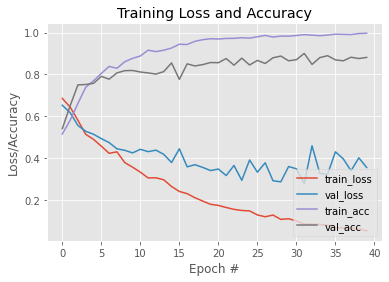

In [34]:
MODEL_PATH = os.path.sep.join(["/content/drive/MyDrive/Kaggle", "siamese_model"])
PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/Kaggle", "newVGG1.png"])


print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...") 
plot_training(history, PLOT_PATH)

In [ ]:
MODEL_PATH = os.path.sep.join(["/content/drive/MyDrive/Kaggle", "siamese_model_VGG"])

from tensorflow.keras.models import load_model
model = load_model(MODEL_PATH)

In [35]:
'''
To predict, input an image (224, 244, 3)
Image will be compared against each class in the dataset
<compCount> dictates how many pairs are generated for each class
'''
def predict(image, compCount, images, labels, idx, siameseModel, unscaledImages, unscaledImage):
  if compCount < 1:
    compCount = 1
  
  pairs = []
  unscaledPairs = []
  
  numClasses = len(np.unique(labels))
  for classNum in range(numClasses):
    # Make <compCount> pairs for each class
    pairMaxCount = min(compCount, len(idx[classNum]))
    pairs.append([])
    unscaledPairs.append([])
    for pairCount in range(pairMaxCount):
      # Pair image with random image from classNum
      # Ideally, we would like to remove the value from 
      # viables image pairs to prevent duplicate pairs
      randomImageIndex = np.random.choice(idx[classNum])
      pairs[classNum].append(images[randomImageIndex])
      unscaledPairs[classNum].append(unscaledImages[randomImageIndex])
  
  # Predict
  prediction = []
  for classNum in range(numClasses):
    pairCount = len(pairs[classNum])
    total = 0
    for pairNum in range(pairCount):
      input = [image.reshape(1, 224,224,3), pairs[classNum][pairNum].reshape(1, 224,224,3)]
      total += siameseModel.predict(input)[0][0]
                              
    avg=total/pairCount
    prediction.append(avg)

  ''' UNCOMMENT TO OUTPUT PAIRS
  print("Input Image:")
  plt.figure(figsize=(10, 10))
  plt.subplot(7, compCount, 1)
  unscaledImage = np.array(unscaledImage).astype("uint8") 
  plt.imshow(unscaledImage, interpolation="nearest")
  count = 0
  for i, lst in enumerate(unscaledPairs):
    print()
    for j, pair in enumerate(lst):
      count += 1
      print("Class Name:", class_names[i], end=" -> ")
      plt.subplot(7, compCount, count + compCount)
      pair = np.array(pair).astype("uint8") 
      plt.imshow(pair, interpolation="nearest")

  print()
  '''
  return prediction

In [36]:
def plot_imgs(item_dir, title=" ", num_imgs=4, cmap='viridis'):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(15, 15))
    for idx, img_path in enumerate(item_files):
        plt.subplot(8, 8, idx+1)
        img = plt.imread(img_path, 0)
        plt.title(title)
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [43]:
'''
imageInd = 5
originalImage = images[imageInd]
predImage = scaledImages[imageInd]
predMat = predict(predImage, 5, images, labels, idx, model, images, originalImage)
print("Labels Matrix:", class_names)
print("Prediction Matrix:", predMat)
print("Predicted Label:", class_names[np.argmax(predMat)])
print("Actual classification:", class_names[labels[imageInd]])

print("---------------------------------------------------")
'''
compCount = 1
labels_pred = []
'''
This commented out block passes each image into the model and attempts to
predict the class
Each class prediction
for i in range(len(images)):
  imageInd = i
  originalImage = images[imageInd]
  predImage = scaledImages[imageInd]
  predMat = predict(predImage, compCount, images, labels, idx, model, images, originalImage)
  prediction = np.argmax(predMat)

  labels_pred.append(prediction)
'''
labels_pred = model.predict([pair_test[:, 0], pair_test[:, 1]])
print(labels_pred)

[[8.8552952e-01]
 [1.0948015e-02]
 [7.0675927e-01]
 ...
 [2.5712407e-13]
 [9.6622944e-01]
 [5.8413384e-06]]


In [44]:
#matrix1 = confusion_matrix(labels, labels_pred)
for i, val in enumerate(labels_pred):
  if val < .5:
    labels_pred[i] = 0
  else:
    labels_pred[i] = 1
matrix1 = confusion_matrix(label_test, labels_pred)

[Text(0, 0.5, 'Different'), Text(0, 1.5, 'Same')]

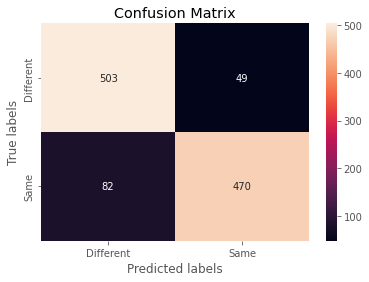

In [46]:
#target_names = ['Bishop','King','Rook','Pawn','Queen','Knight']
target_names = ["Different", "Same"]

ax= plt.subplot()
sns.heatmap(matrix1, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names)

In [ ]:
class_names = ['Bishop', 'King','Knight','Pawn','Queen','Rook']
dirname = "/content/drive/MyDrive/Kaggle/Chessman-image-dataset/Chess"

dir_chess_folders = os.listdir(dirname)
dir_chess_paths = [os.path.join(dirname, path) for path in dir_chess_folders]

for path in dir_chess_paths:
    head, tail = os.path.split(path)
    plot_imgs(path, tail, 8)